In [21]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [37]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import unicodedata
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [39]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
nltk.download('stopwords')
nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozkan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ozkan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ozkan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ozkan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
df = pd.read_csv("wiki_data.csv", sep=",")
df.head()

,Unnamed: 0,text
0,1,Anovo\n\nAnovo (formerly A Novo) is a computer...
1,2,Battery indicator\n\nA battery indicator (also...
2,3,"Bob Pease\n\nRobert Allen Pease (August 22, 19..."
3,4,CAVNET\n\nCAVNET was a secure military forum w...
4,5,CLidar\n\nThe CLidar is a scientific instrumen...


In [43]:
import pandas as pd
import unicodedata

def clean_text(df: pd.DataFrame, col: str, remove_accents=False) -> pd.DataFrame:
    df[col] = df[col].str.lower()

    if remove_accents:
        df[col] = df[col].apply(
            lambda x: unicodedata.normalize('NFD', x)
                      .encode('ascii', 'ignore')
                      .decode('utf-8')
        )
    
    df[col] = df[col].str.replace(r'[^\w\s]', '', regex=True)
    df[col] = df[col].str.replace(r'\d+', '', regex=True)
    df[col] = df[col].str.replace(r'\n+', ' ', regex=True)    
    df[col] = df[col].str.strip().str.replace(r'\s+', ' ', regex=True)

    return df

In [45]:
df = clean_text(df, "text", remove_accents=True)

In [47]:
remove_stopwords  = stopwords.words('english') + stopwords.words('french') + stopwords.words('german') 

df['text']  = df['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in remove_stopwords ))

In [49]:
temp_df = pd.Series(' '.join(df['text']).split()).value_counts()
drops = temp_df[temp_df <= 1000]

df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [51]:
df['text'] = df['text'].apply(lambda x: TextBlob(x).words)

In [53]:
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

In [55]:
tf = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]         #  ---> indexi resetleyip yeniden adlandiriyoruz. daha anlamli olmasi icin
tf.sort_values("tf", ascending=False)

,words,tf
21,used,29402.00
22,system,26873.00
33,use,16820.00
224,one,15929.00
133,first,15284.00
...,...,...
722,normal,1004.00
757,valve,1002.00
40,damage,1002.00
719,angle,1001.00


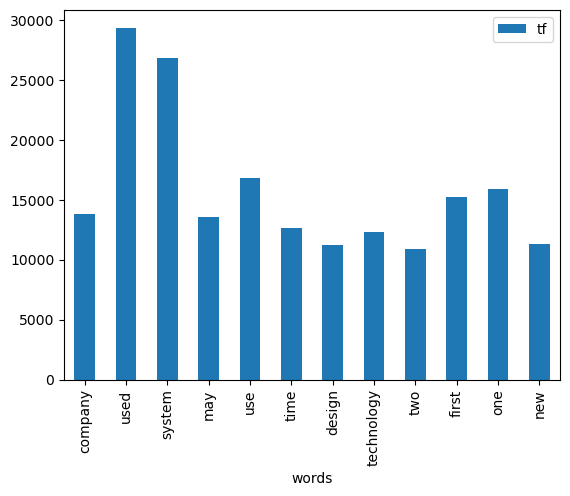

In [57]:
tf[tf["tf"] > 10000].plot.bar(x="words", y="tf")
plt.show()

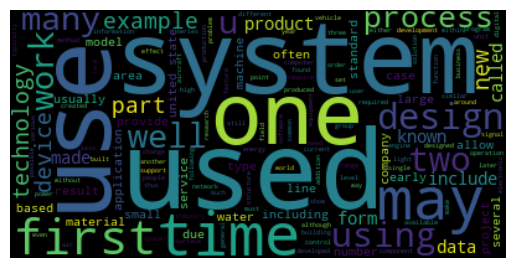

In [59]:
df['text']

text = " ".join(i for i in df.text)  # --> tum kelimeler bir araya getirirldi

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

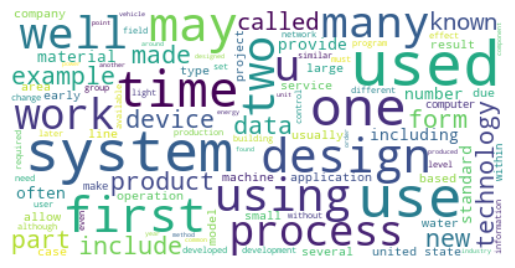

In [61]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [75]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from wordcloud import WordCloud

def wiki_nlp_wordcloud(col='text'):
    try:
        # --- Veri setini oku ---
        df = pd.read_csv("wiki_data.csv", sep=",")
        print(f"✅ Veriseti yüklendi: {df.shape[0]} satır, {df.shape[1]} sütun")

        # --- Metin temizleme fonksiyonu ---
        def clean_text(text, remove_accents=False):
            text = str(text).lower()
            if remove_accents:
                text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'\d+', '', text)
            text = re.sub(r'\n+', ' ', text)
            text = re.sub(r'\s+', ' ', text).strip()
            return text

        # --- Temizleme işlemi ---
        df[col] = df[col].apply(lambda x: clean_text(x, remove_accents=True))

        # --- Stopword temizliği ---
        remove_stopwords = stopwords.words('english') + stopwords.words('french') + stopwords.words('german')
        df[col] = df[col].apply(lambda x: " ".join(w for w in x.split() if w not in remove_stopwords))

        # --- Nadir kelimeleri kaldır ---
        temp_series = pd.Series(' '.join(df[col]).split()).value_counts()
        drops = temp_series[temp_series <= 1000].index
        df[col] = df[col].apply(lambda x: " ".join(w for w in x.split() if w not in drops))

        # --- Lemmatization ---
        df[col] = df[col].apply(lambda x: " ".join([Word(word).lemmatize() for word in TextBlob(x).words]))

        # --- Kelime frekans grafiği ---
        tf = df[col].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
        tf.columns = ["words", "tf"]
        top_words = tf[tf["tf"] > 10000]
        print(f"📊 En sık kullanılan {len(top_words)} kelime gösteriliyor.")
        top_words.plot.bar(x="words", y="tf", figsize=(10,5), title="Word Frequency (>10k)")
        plt.show()

        # --- WordCloud oluştur ---
        all_text = ' '.join(df[col])
        wordcloud = WordCloud(max_font_size=60, max_words=150, background_color="white").generate(all_text)
        plt.figure(figsize=(10,6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Wikipedia Text WordCloud", fontsize=16)
        plt.show()

    except FileNotFoundError:
        print("❌ Hata: 'wiki_data.csv' dosyası bulunamadı.")
    except pd.errors.EmptyDataError:
        print("❌ Hata: CSV dosyası boş.")
    except Exception as e:
        print("⚠️ Beklenmeyen bir hata oluştu:", e)
    finally:
        print("✅ İşlem tamamlandı.")

✅ Veriseti yüklendi: 10859 satır, 2 sütun
📊 En sık kullanılan 12 kelime gösteriliyor.


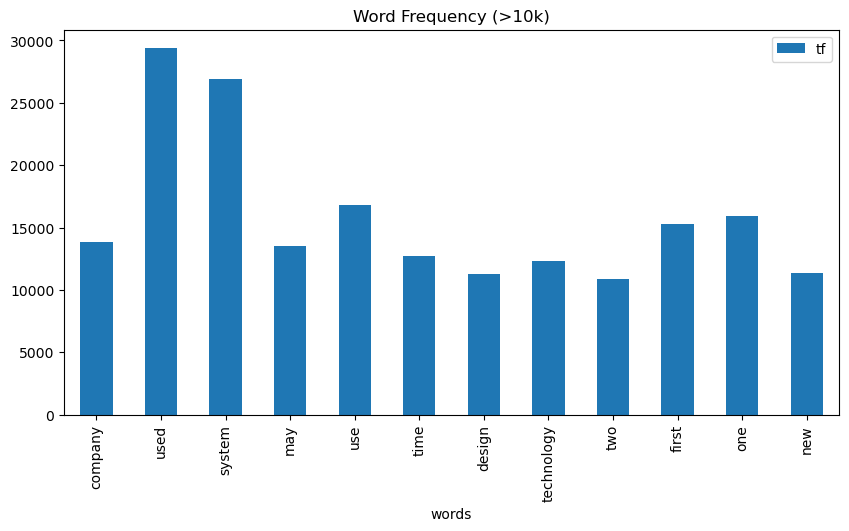

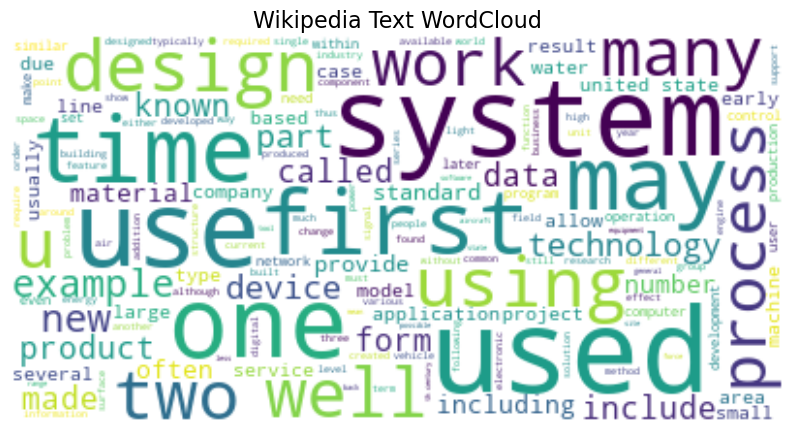

✅ İşlem tamamlandı.


In [77]:
wiki_nlp_wordcloud(col='text')